In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
wordsforthewise_lending_club_path = kagglehub.dataset_download('wordsforthewise/lending-club')

print('Data source import complete.')


100%|██████████| 1.26G/1.26G [00:07<00:00, 174MB/s]

Extracting files...


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Task 1

In [ ]:
import os

# List files in the directory downloaded by kagglehub
# The path is stored in wordsforthewise_lending_club_path
downloaded_path = wordsforthewise_lending_club_path

print(f"Listing files in: {downloaded_path}")
for root, dirs, files in os.walk(downloaded_path):
    for name in files:
        print(os.path.join(root, name))
    for name in dirs:
        print(os.path.join(root, name))

Listing files in: /root/.cache/kagglehub/datasets/wordsforthewise/lending-club/versions/3
/root/.cache/kagglehub/datasets/wordsforthewise/lending-club/versions/3/accepted_2007_to_2018Q4.csv.gz
/root/.cache/kagglehub/datasets/wordsforthewise/lending-club/versions/3/rejected_2007_to_2018Q4.csv.gz
/root/.cache/kagglehub/datasets/wordsforthewise/lending-club/versions/3/accepted_2007_to_2018q4.csv
/root/.cache/kagglehub/datasets/wordsforthewise/lending-club/versions/3/rejected_2007_to_2018q4.csv
/root/.cache/kagglehub/datasets/wordsforthewise/lending-club/versions/3/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/root/.cache/kagglehub/datasets/wordsforthewise/lending-club/versions/3/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


### LOAD DATA AND INITIAL EDA


Data loaded successfully. Shape: (2260701, 151)

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB

--- Data Head ---
         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade                    emp_title  \
0     13.99       123.03     C        C4                      leadman   
1     11.99       820.28     C        C1                     Engineer   
2     10.78       432.66     B   

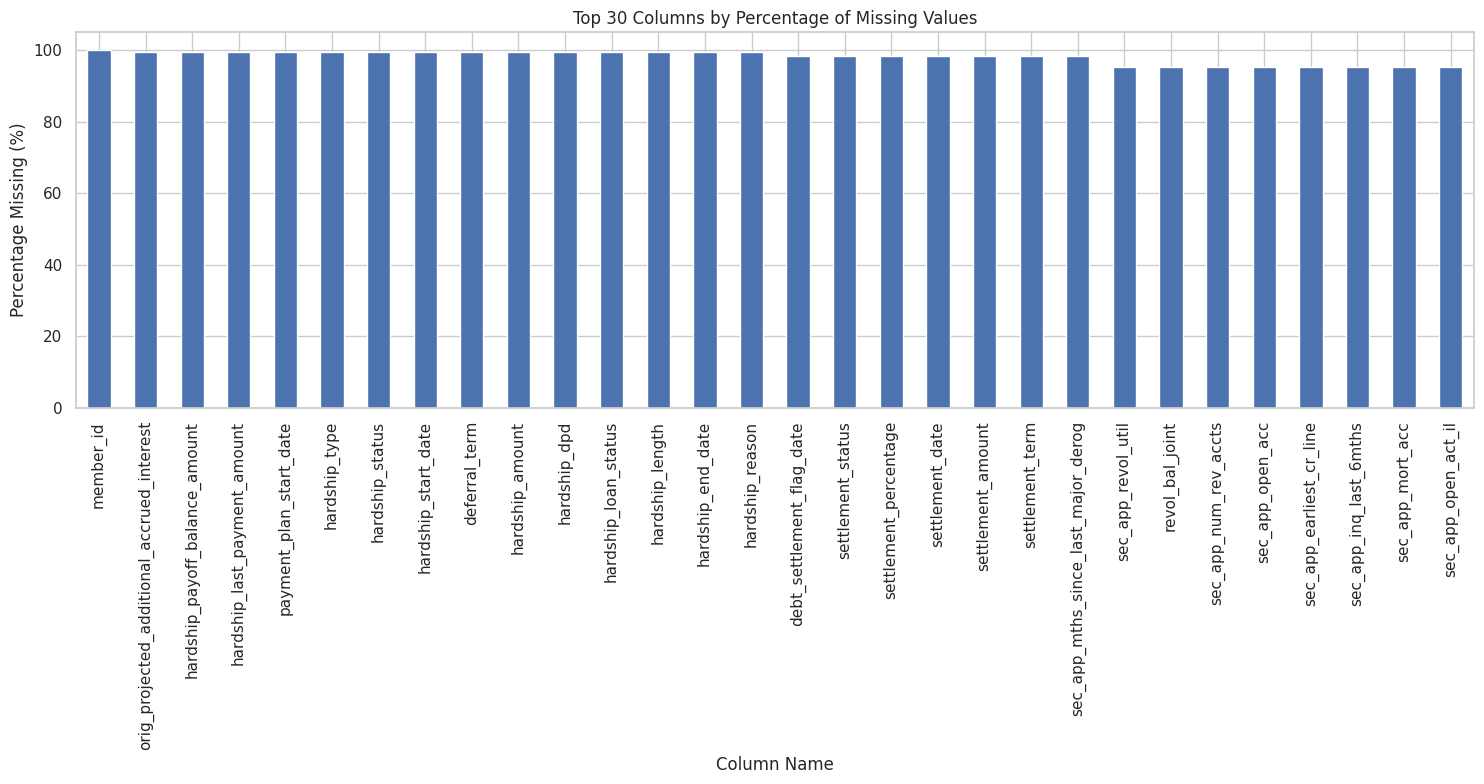

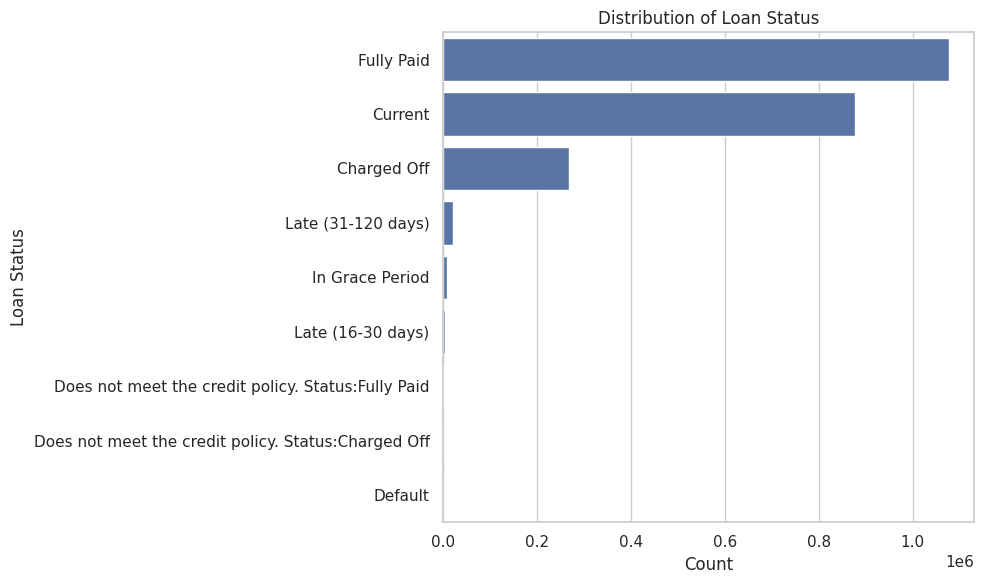

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# 1. Load the dataset
# The path from kagglehub download is stored in wordsforthewise_lending_club_path
data_path = wordsforthewise_lending_club_path + '/accepted_2007_to_2018Q4.csv.gz' # Added .gz
try:
    # Added compression='gzip'
    df = pd.read_csv(data_path, low_memory=False, compression='gzip')
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {data_path}. Please ensure file is in the directory.")
    raise

# 2. Initial inspection
print("\n--- Initial Data Info ---")
df.info()

print("\n--- Data Head ---")
pd.set_option('display.max_columns', None)
print(df.head())

# 3. Analyze missing values
print("\n--- Missing Value Analysis ---")
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

print(f"There are {len(missing_pct)} columns with missing values.")
print("Top 20 columns with missing values:")
print(missing_pct.head(20))

# Visualize the top missing value columns
plt.figure(figsize=(15, 8))
missing_pct.head(30).plot(kind='bar')
plt.title('Top 30 Columns by Percentage of Missing Values')
plt.ylabel('Percentage Missing (%)')
plt.xlabel('Column Name')
plt.tight_layout()
plt.savefig('missing_values.png')
print("\nSaved plot 'missing_values.png'")

# 4. Analyze the target variable: 'loan_status'
print("\n--- Loan Status Distribution ---")
print(df['loan_status'].value_counts(normalize=True))

plt.figure(figsize=(10, 6))
sns.countplot(y=df['loan_status'], order=df['loan_status'].value_counts().index)
plt.title('Distribution of Loan Status')
plt.xlabel('Count')
plt.ylabel('Loan Status')
plt.tight_layout()
plt.savefig('loan_status_distribution.png')
print("Saved plot 'loan_status_distribution.png'")

### TARGET DEFINITION AND FEATURE SELECTION

In [ ]:


# 1. Define target variable 'is_default'
target_map = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Default': 1
}

df['is_default'] = df['loan_status'].map(target_map)

# 2. Filter the DataFrame - keep only final statuses
df_filtered = df.dropna(subset=['is_default']).copy()
df_filtered['is_default'] = df_filtered['is_default'].astype(int)

print(f"Original shape: {df.shape}")
print(f"Filtered shape: {df_filtered.shape}")
print(f"\nTarget distribution:\n{df_filtered['is_default'].value_counts(normalize=True)}")

# 3. EXPANDED feature list with more predictive features
feature_list = [
    # Loan Conditions
    'loan_amnt',
    'funded_amnt',
    'int_rate',
    'term',
    'installment',
    'grade',
    'sub_grade',
    'purpose',

    # Borrower's Credit History
    'fico_range_low',
    'fico_range_high',
    'dti',
    'revol_util',
    'revol_bal',
    'pub_rec',
    'pub_rec_bankruptcies',
    'delinq_2yrs',
    'inq_last_6mths',
    'open_acc',
    'total_acc',
    'earliest_cr_line',

    # Borrower's Capacity
    'annual_inc',
    'emp_length',
    'home_ownership',
    'verification_status',
    'addr_state'
]

target_col = 'is_default'

# 4. Create modeling DataFrame
df_model = df_filtered[feature_list + [target_col]].copy()

print(f"\nShape before handling missing values: {df_model.shape}")

# 5. Check missing values in selected features
print("\nMissing values in selected features:")
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])



Original shape: (2260701, 152)
Filtered shape: (1345350, 152)

Target distribution:
is_default
0    0.80035
1    0.19965
Name: proportion, dtype: float64

Shape before handling missing values: (1345350, 26)

Missing values in selected features:
dti                       374
revol_util                857
pub_rec_bankruptcies      697
inq_last_6mths              1
emp_length              78516
dtype: int64


### ADVANCED PREPROCESSING WITH PROPER FEATURE ENGINEERING

In [ ]:


from sklearn.model_selection import train_test_split

# 1. Feature engineering BEFORE any preprocessing
df_clean = df_model.copy()

# Convert percentage strings
df_clean['int_rate'] = df_clean['int_rate'].astype(str).str.replace('%', '', regex=False)
df_clean['int_rate'] = pd.to_numeric(df_clean['int_rate'], errors='coerce')

df_clean['revol_util'] = df_clean['revol_util'].astype(str).str.replace('%', '', regex=False)
df_clean['revol_util'] = pd.to_numeric(df_clean['revol_util'], errors='coerce')

# Convert term to numeric
df_clean['term'] = df_clean['term'].astype(str).str.extract('(\d+)').astype(float)

# Process emp_length (handle "< 1 year", "10+ years", etc.)
def process_emp_length(x):
    if pd.isna(x):
        return np.nan
    x = str(x).lower()
    if '< 1' in x:
        return 0.5
    elif '10+' in x or '10 +' in x:
        return 10
    else:
        try:
            return float(''.join(filter(str.isdigit, x)))
        except:
            return np.nan

df_clean['emp_length'] = df_clean['emp_length'].apply(process_emp_length)

# Process earliest_cr_line to get credit history length
df_clean['earliest_cr_line'] = pd.to_datetime(df_clean['earliest_cr_line'], format='%b-%Y', errors='coerce')
reference_date = pd.to_datetime('2018-12-31')  # End of dataset
df_clean['credit_history_years'] = (reference_date - df_clean['earliest_cr_line']).dt.days / 365.25
df_clean = df_clean.drop(columns=['earliest_cr_line'])

# Create new engineered features
df_clean['loan_to_income'] = df_clean['loan_amnt'] / (df_clean['annual_inc'] + 1)
df_clean['fico_avg'] = (df_clean['fico_range_low'] + df_clean['fico_range_high']) / 2
df_clean['installment_to_income'] = df_clean['installment'] / (df_clean['annual_inc'] / 12 + 1)
df_clean['revol_bal_to_income'] = df_clean['revol_bal'] / (df_clean['annual_inc'] + 1)

print("--- Features after engineering ---")
print(df_clean.head())

# 2. Handle missing values strategically
# For numeric features with missing values, impute with median
numeric_cols_to_impute = ['revol_util', 'emp_length', 'pub_rec_bankruptcies',
                          'credit_history_years', 'dti', 'revol_bal']

for col in numeric_cols_to_impute:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# For categorical, fill with 'Unknown' or most frequent
categorical_cols = ['emp_length', 'home_ownership', 'verification_status', 'purpose',
                   'addr_state', 'grade', 'sub_grade']

for col in categorical_cols:
    if col in df_clean.columns and df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].fillna('Unknown')

# Drop remaining rows with NaN (should be minimal now)
df_clean = df_clean.dropna()

print(f"\nShape after handling missing values: {df_clean.shape}")
print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")

# 3. CRITICAL: Split data FIRST, then preprocess
X = df_clean.drop(columns=target_col)
y = df_clean[target_col]

# Stratified split: 64% train, 16% val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

print(f"\nTraining set: {X_train.shape}, Default rate: {y_train.mean():.4f}")
print(f"Validation set: {X_val.shape}, Default rate: {y_val.mean():.4f}")
print(f"Test set: {X_test.shape}, Default rate: {y_test.mean():.4f}")

# 4. Define preprocessing transformers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define feature types
numeric_features = [
    'loan_amnt', 'funded_amnt', 'int_rate', 'term', 'installment',
    'fico_range_low', 'fico_range_high', 'dti', 'revol_util', 'revol_bal',
    'pub_rec', 'pub_rec_bankruptcies', 'delinq_2yrs', 'inq_last_6mths',
    'open_acc', 'total_acc', 'annual_inc', 'emp_length',
    'credit_history_years', 'loan_to_income', 'fico_avg',
    'installment_to_income', 'revol_bal_to_income'
]

categorical_features = [
    'grade', 'sub_grade', 'purpose', 'home_ownership',
    'verification_status', 'addr_state'
]

# Keep only features that exist in our data
numeric_features = [f for f in numeric_features if f in X_train.columns]
categorical_features = [f for f in categorical_features if f in X_train.columns]

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features[:5]}...")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# 5. Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=50))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 6. Fit ONLY on training data, then transform all sets
print("\nFitting preprocessor on TRAINING data only...")
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

print(f"\nProcessed shapes:")
print(f"Train: {X_train_processed.shape}")
print(f"Val: {X_val_processed.shape}")
print(f"Test: {X_test_processed.shape}")
print(f"Total features after encoding: {len(feature_names)}")

# 7. Convert to DataFrames and save
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_val_df = pd.DataFrame(X_val_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

# Reset indices to align with labels
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Save processed data
train_data = pd.concat([X_train_df, y_train], axis=1)
val_data = pd.concat([X_val_df, y_val], axis=1)
test_data = pd.concat([X_test_df, y_test], axis=1)

train_data.to_parquet('processed_train.parquet', index=False)
val_data.to_parquet('processed_val.parquet', index=False)
test_data.to_parquet('processed_test.parquet', index=False)

print("\n✓ Successfully saved processed data:")
print("  - processed_train.parquet")
print("  - processed_val.parquet")
print("  - processed_test.parquet")

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-770589634.py:16: SyntaxWarning: invalid escape sequence '\d'
  df_clean['term'] = df_clean['term'].astype(str).str.extract('(\d+)').astype(float)


--- Features after engineering ---
   loan_amnt  funded_amnt  int_rate  term  installment grade sub_grade  \
0     3600.0       3600.0     13.99  36.0       123.03     C        C4   
1    24700.0      24700.0     11.99  36.0       820.28     C        C1   
2    20000.0      20000.0     10.78  60.0       432.66     B        B4   
4    10400.0      10400.0     22.45  60.0       289.91     F        F1   
5    11950.0      11950.0     13.44  36.0       405.18     C        C3   

              purpose  fico_range_low  fico_range_high    dti  revol_util  \
0  debt_consolidation           675.0            679.0   5.91        29.7   
1      small_business           715.0            719.0  16.06        19.2   
2    home_improvement           695.0            699.0  10.78        56.2   
4      major_purchase           695.0            699.0  25.37        64.5   
5  debt_consolidation           690.0            694.0  10.20        68.4   

   revol_bal  pub_rec  pub_rec_bankruptcies  delinq_2yrs 

## Task 2


### SETUP AND DATA LOADING

In [ ]:


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.metrics import (roc_auc_score, f1_score, confusion_matrix,
                             classification_report, precision_recall_curve,
                             average_precision_score, roc_curve, recall_score, precision_score)
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# 1. Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# 2. Load the processed data
try:
    train_df = pd.read_parquet('processed_train.parquet')
    val_df = pd.read_parquet('processed_val.parquet')
    test_df = pd.read_parquet('processed_test.parquet')
    print(f"✓ Loaded processed data")
    print(f"  Train: {train_df.shape}")
    print(f"  Val: {val_df.shape}")
    print(f"  Test: {test_df.shape}")
except FileNotFoundError:
    print("Error: Processed parquet files not found. Run preprocessing first.")
    raise

# 3. Split features and target
target_col = 'is_default'

X_train = train_df.drop(columns=target_col)
y_train = train_df[target_col]

X_val = val_df.drop(columns=target_col)
y_val = val_df[target_col]

X_test = test_df.drop(columns=target_col)
y_test = test_df[target_col]

input_features = X_train.shape[1]
print(f"\nNumber of input features: {input_features}")

# Check class distribution
print(f"\nClass distribution:")
print(f"  Train - Default rate: {y_train.mean():.4f} (Defaults: {y_train.sum():,}, Paid: {(1-y_train).sum():,})")
print(f"  Val   - Default rate: {y_val.mean():.4f}")
print(f"  Test  - Default rate: {y_test.mean():.4f}")



Using device: cuda
GPU: Tesla T4
✓ Loaded processed data
  Train: (861023, 139)
  Val: (215256, 139)
  Test: (269070, 139)

Number of input features: 138

Class distribution:
  Train - Default rate: 0.1996 (Defaults: 171,903, Paid: 689,120)
  Val   - Default rate: 0.1997
  Test  - Default rate: 0.1997


### CREATE PYTORCH DATASETS WITH AGGRESSIVE WEIGHTED SAMPLING

In [ ]:

class LoanDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create Dataset instances
train_dataset = LoanDataset(X_train, y_train)
val_dataset = LoanDataset(X_val, y_val)
test_dataset = LoanDataset(X_test, y_test)

# AGGRESSIVE WEIGHTED SAMPLING - Oversample minority class more
class_counts = np.bincount(y_train.astype(int))
# Instead of 1/count, use more aggressive weighting for minority class
minority_boost = 1 # Boost minority class sampling
class_weights = np.array([1.0, minority_boost * class_counts[0] / class_counts[1]])
sample_weights = class_weights[y_train.astype(int)]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create DataLoaders with smaller batch size for better gradient updates
BATCH_SIZE = 256  # Reduced for better gradient signal

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"\n✓ DataLoaders created with aggressive weighted sampling")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Minority class boost factor: {minority_boost}")
print(f"  Effective class weights: [1.0, {class_weights[1]:.2f}]")




✓ DataLoaders created with aggressive weighted sampling
  Batch size: 256
  Minority class boost factor: 1
  Effective class weights: [1.0, 4.01]


### DEFINE IMPROVED MLP WITH FOCAL LOSS

In [ ]:
class FocalLoss(nn.Module):
    """
    Focal Loss - helps with hard examples and class imbalance
    FL(p_t) = -alpha * (1 - p_t)^gamma * log(p_t)
    """
    def __init__(self, alpha=0.3, gamma=2.5, pos_weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        # Apply sigmoid to get probabilities
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none', pos_weight=self.pos_weight
        )
        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)

        # Focal term
        focal_term = (1 - p_t) ** self.gamma

        # Alpha balancing
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        loss = alpha_t * focal_term * BCE_loss
        return loss.mean()


class EnhancedMLP(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.35):
        super(EnhancedMLP, self).__init__()

        # Wider and deeper network
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 896),
            nn.BatchNorm1d(896),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(896, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.9)
        )

        self.layer4 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.8)
        )

        self.layer5 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6)
        )

        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        out = self.output(x)
        return out

# Instantiate model
model = EnhancedMLP(input_dim=input_features, dropout_rate=0.35).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n✓ Enhanced Model created")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# MANUAL POSITIVE CLASS WEIGHT TUNING
# Original ratio: ~4.13 (80% paid / 20% default)
# Let's try different weights to find the sweet spot

MANUAL_POS_WEIGHT = 2.0  # Start with higher weight to boost recall
# Try: 5.0, 6.0, 7.0, 8.0, 9.0 for different precision-recall tradeoffs

pos_weight_tensor = torch.tensor([MANUAL_POS_WEIGHT], dtype=torch.float32).to(device)
print(f"\n🎯 Loss Function Configuration:")
print(f"  Manual Positive Class Weight: {MANUAL_POS_WEIGHT}")
print(f"  Using Focal Loss with alpha=0.25, gamma=2.0")

# Use Focal Loss for better handling of hard examples
criterion = FocalLoss(alpha=0.3, gamma=2.5, pos_weight=pos_weight_tensor)

# Optimizer with lower learning rate and stronger regularization
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.03)

# Cosine Annealing with Warm Restarts - better than ReduceLROnPlateau
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)




✓ Enhanced Model created
  Total parameters: 760,065
  Trainable parameters: 760,065

🎯 Loss Function Configuration:
  Manual Positive Class Weight: 2.0
  Using Focal Loss with alpha=0.25, gamma=2.0


### TRAINING WITH ENHANCED MONITORING


Starting Enhanced Training
Epoch [  1/30] | Loss: 0.0732/0.0700 | AUC: 0.7192 | F1: 0.4344 | P: 0.3492 | R: 0.5747 | LR: 0.000293
  ✓ NEW BEST! AUC: 0.7192, F1: 0.4344, Composite: 0.6052
Epoch [  2/30] | Loss: 0.0717/0.0699 | AUC: 0.7209 | F1: 0.4355 | P: 0.3500 | R: 0.5763 | LR: 0.000271
  ✓ NEW BEST! AUC: 0.7209, F1: 0.4355, Composite: 0.6067
Epoch [  3/30] | Loss: 0.0715/0.0693 | AUC: 0.7220 | F1: 0.4376 | P: 0.3445 | R: 0.5998 | LR: 0.000238
  ✓ NEW BEST! AUC: 0.7220, F1: 0.4376, Composite: 0.6083
Epoch [  4/30] | Loss: 0.0713/0.0698 | AUC: 0.7226 | F1: 0.4374 | P: 0.3487 | R: 0.5868 | LR: 0.000197
  ✓ NEW BEST! AUC: 0.7226, F1: 0.4374, Composite: 0.6086
Epoch [  5/30] | Loss: 0.0711/0.0678 | AUC: 0.7221 | F1: 0.4362 | P: 0.3544 | R: 0.5671 | LR: 0.000150
Epoch [  6/30] | Loss: 0.0710/0.0682 | AUC: 0.7231 | F1: 0.4378 | P: 0.3553 | R: 0.5702 | LR: 0.000104
  ✓ NEW BEST! AUC: 0.7231, F1: 0.4378, Composite: 0.6090
Epoch [  7/30] | Loss: 0.0709/0.0690 | AUC: 0.7236 | F1: 0.4393 | P: 

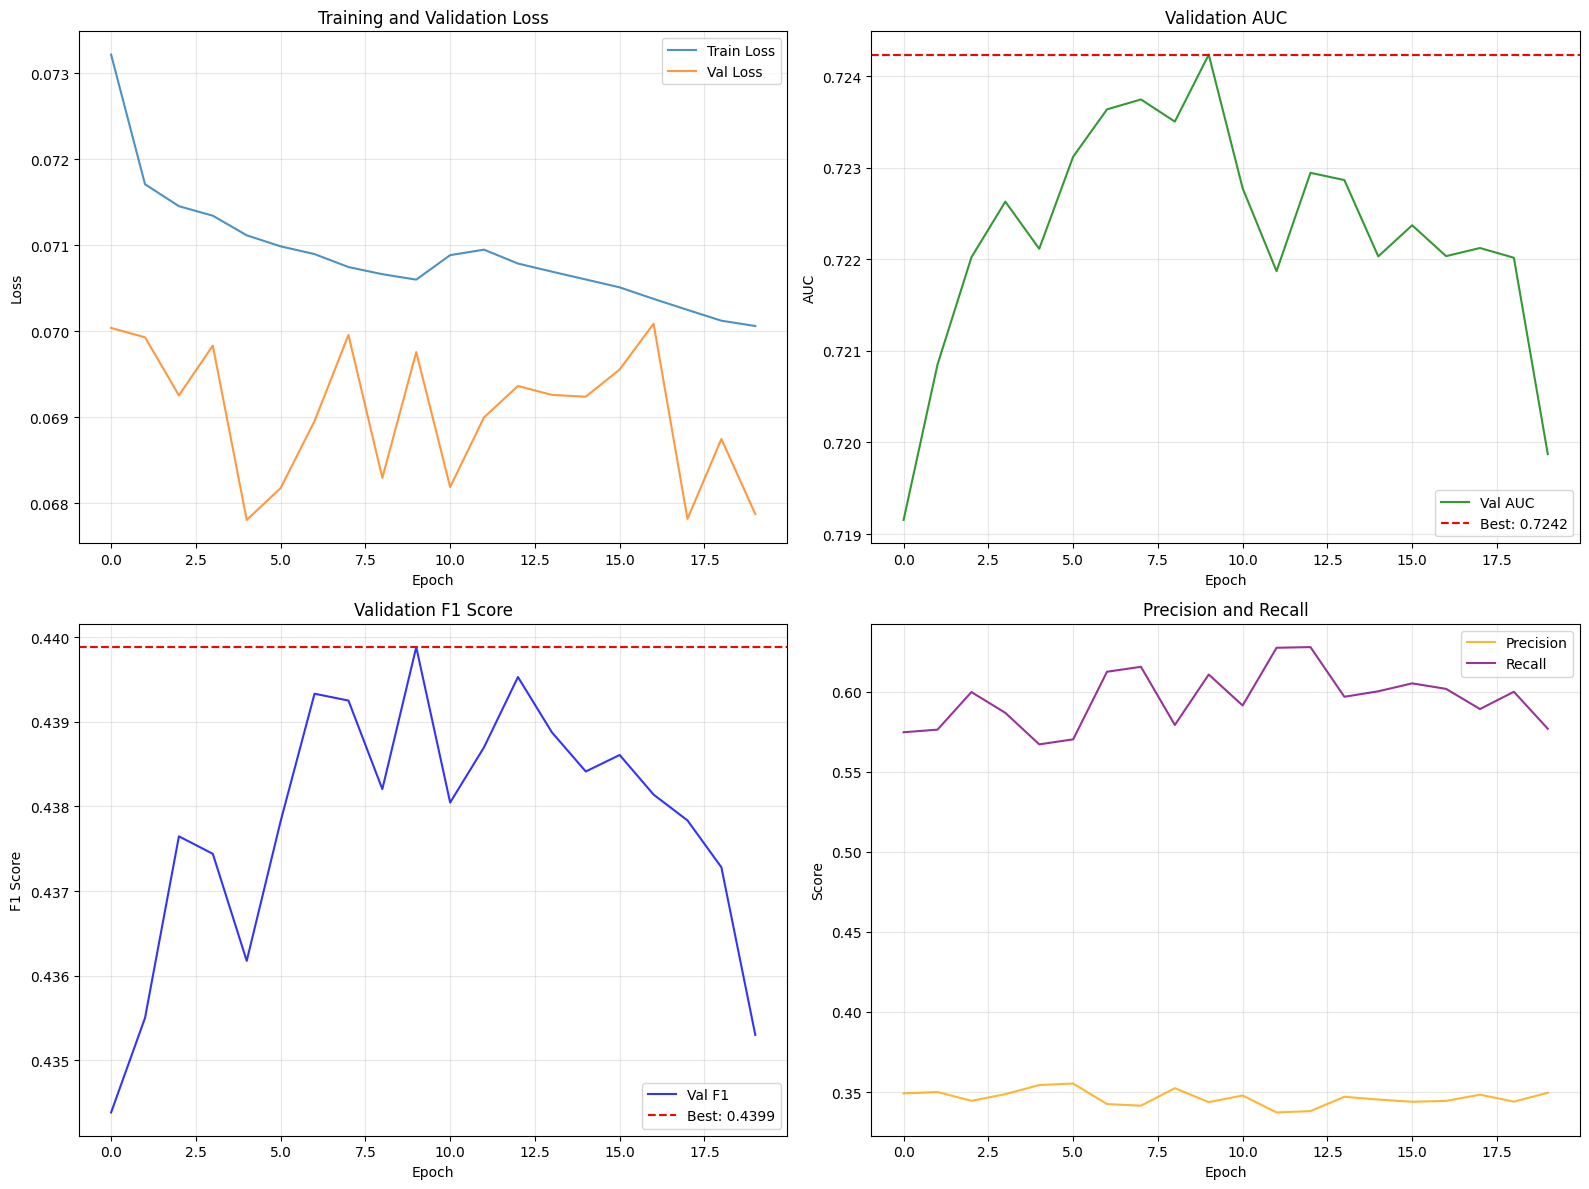

In [ ]:
NUM_EPOCHS = 30
EARLY_STOPPING_PATIENCE = 10
best_val_f1 = 0.0
best_val_auc = 0.0
patience_counter = 0

BEST_MODEL_PATH = 'best_dl_model_enhanced.pth'

# Tracking metrics
train_losses = []
val_losses = []
val_aucs = []
val_f1s = []
val_recalls = []
val_precisions = []

print("\n" + "="*60)
print("Starting Enhanced Training")
print("="*60)

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    train_loss = 0.0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features).squeeze()
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_preds_list = []
    val_probs_list = []
    val_labels_list = []

    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)

            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get probabilities
            probs = torch.sigmoid(outputs)
            val_probs_list.extend(probs.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_probs_array = np.array(val_probs_list)
    val_labels_array = np.array(val_labels_list)

    # Calculate validation metrics
    val_auc = roc_auc_score(val_labels_array, val_probs_array)
    val_aucs.append(val_auc)

    # Use 0.5 threshold for F1 calculation during training
    val_preds_05 = (val_probs_array >= 0.5).astype(int)
    val_f1 = f1_score(val_labels_array, val_preds_05)
    val_recall = recall_score(val_labels_array, val_preds_05)
    val_precision = precision_score(val_labels_array, val_preds_05)

    val_f1s.append(val_f1)
    val_recalls.append(val_recall)
    val_precisions.append(val_precision)

    # Learning rate scheduler step
    scheduler.step()

    # Print progress
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}] | "
          f"Loss: {avg_train_loss:.4f}/{avg_val_loss:.4f} | "
          f"AUC: {val_auc:.4f} | "
          f"F1: {val_f1:.4f} | "
          f"P: {val_precision:.4f} | "
          f"R: {val_recall:.4f} | "
          f"LR: {current_lr:.6f}")

    # Save best model based on combination of AUC and F1
    composite_score = 0.6 * val_auc + 0.4 * val_f1  # Weighted combination
    best_composite = 0.6 * best_val_auc + 0.4 * best_val_f1

    if composite_score > best_composite:
        best_val_auc = val_auc
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_auc,
            'val_f1': val_f1,
            'val_loss': avg_val_loss,
            'pos_weight': MANUAL_POS_WEIGHT,
        }, BEST_MODEL_PATH)
        print(f"  ✓ NEW BEST! AUC: {val_auc:.4f}, F1: {val_f1:.4f}, Composite: {composite_score:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n⚠ Early stopping at epoch {epoch+1}")
            break

print("\n" + "="*60)
print("Training Complete")
print("="*60)
print(f"Best validation AUC: {best_val_auc:.4f}")
print(f"Best validation F1: {best_val_f1:.4f}")

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(train_losses, label='Train Loss', alpha=0.8)
axes[0, 0].plot(val_losses, label='Val Loss', alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# AUC
axes[0, 1].plot(val_aucs, label='Val AUC', color='green', alpha=0.8)
axes[0, 1].axhline(y=best_val_auc, color='r', linestyle='--', label=f'Best: {best_val_auc:.4f}')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Validation AUC')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 Score
axes[1, 0].plot(val_f1s, label='Val F1', color='blue', alpha=0.8)
axes[1, 0].axhline(y=best_val_f1, color='r', linestyle='--', label=f'Best: {best_val_f1:.4f}')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Validation F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Precision & Recall
axes[1, 1].plot(val_precisions, label='Precision', color='orange', alpha=0.8)
axes[1, 1].plot(val_recalls, label='Recall', color='purple', alpha=0.8)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Precision and Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('enhanced_training_history.png', dpi=150)
print("\n✓ Saved training history")


### COMPREHENSIVE EVALUATION WITH MULTIPLE THRESHOLDS


Loading Best Model for Evaluation
Best model from epoch 10
  Validation AUC: 0.7242
  Validation F1: 0.4399
  Pos Weight Used: 2.00

Generating predictions...

PERFORMANCE METRICS

📊 AUC Scores:
  Train AUC: 0.7346
  Val AUC:   0.7242
  Test AUC:  0.7226

🎯 Finding Optimal Thresholds:

  Method 1 - Max F1: 0.4946 (F1: 0.4403)
  Method 2 - Balanced P/R: 0.5303
  Method 3 - Youden's J: 0.4876

📈 Test Set Results with Different Thresholds:

Method               Threshold    AUC        F1         Precision    Recall    
-------------------------------------------------------------------------------------
Max F1               0.4946       0.7226     0.4385     0.3328       0.6425    
Balanced P/R         0.5303       0.7226     0.4076     0.4066       0.4085    
Youden's J           0.4876       0.7226     0.4361     0.3209       0.6804    
Default (0.5)        0.5000       0.7226     0.4380     0.3417       0.6099    

FINAL TEST RESULTS (Threshold = 0.4946)

  AUC-ROC: 0.7226
  F1-Score:

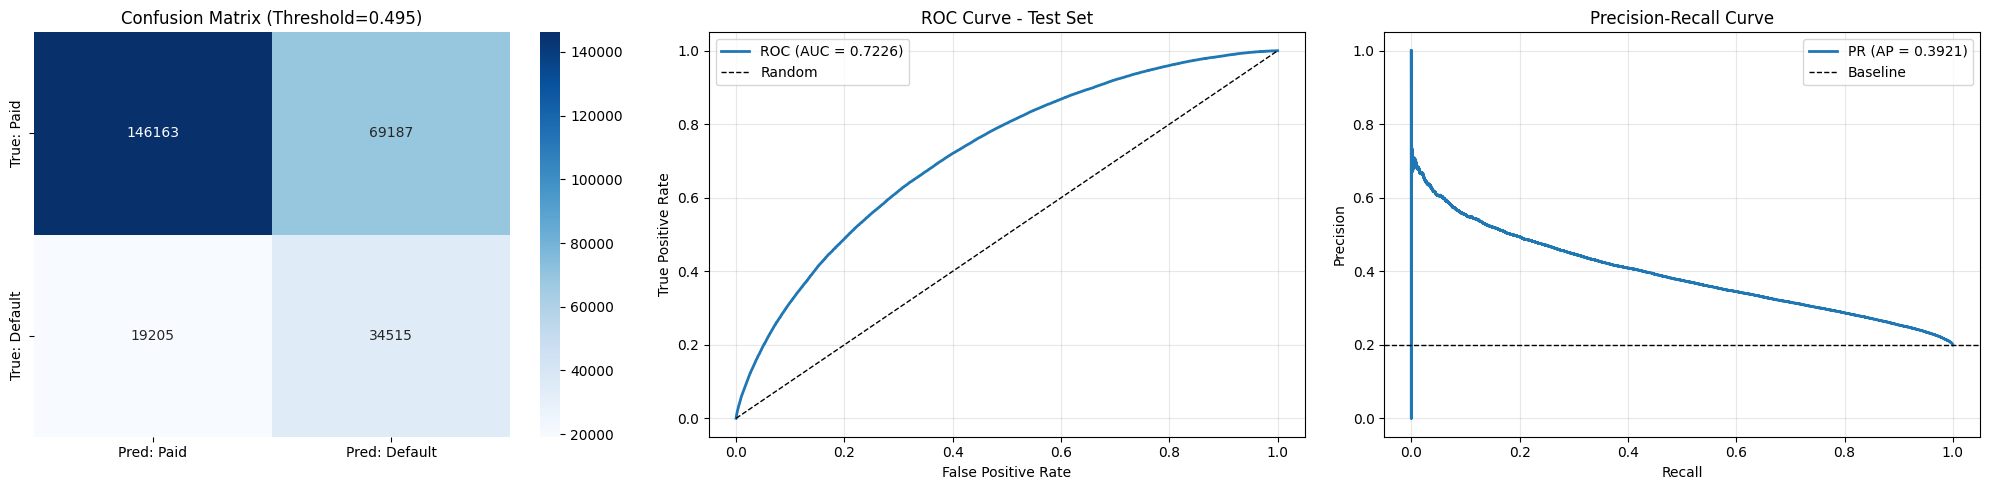

In [ ]:


print("\n" + "="*60)
print("Loading Best Model for Evaluation")
print("="*60)

# Load best model
checkpoint = torch.load(BEST_MODEL_PATH, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"Best model from epoch {checkpoint['epoch']+1}")
print(f"  Validation AUC: {checkpoint['val_auc']:.4f}")
print(f"  Validation F1: {checkpoint['val_f1']:.4f}")
print(f"  Pos Weight Used: {checkpoint['pos_weight']:.2f}")

# Get predictions
def get_predictions(loader, model):
    all_labels = []
    all_probs = []
    model.eval()
    with torch.no_grad():
        for features, labels in loader:
            features = features.to(device)
            outputs = model(features).squeeze()
            probs = torch.sigmoid(outputs)

            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_probs)

print("\nGenerating predictions...")
train_labels, train_probs = get_predictions(train_loader, model)
val_labels, val_probs = get_predictions(val_loader, model)
test_labels, test_probs = get_predictions(test_loader, model)

print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)

# Calculate AUC for all sets
train_auc = roc_auc_score(train_labels, train_probs)
val_auc = roc_auc_score(val_labels, val_probs)
test_auc = roc_auc_score(test_labels, test_probs)

print(f"\n📊 AUC Scores:")
print(f"  Train AUC: {train_auc:.4f}")
print(f"  Val AUC:   {val_auc:.4f}")
print(f"  Test AUC:  {test_auc:.4f}")

# Find optimal threshold using MULTIPLE criteria
print(f"\n🎯 Finding Optimal Thresholds:")

# Method 1: Maximize F1
precision, recall, thresholds_pr = precision_recall_curve(val_labels, val_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_f1_idx = np.argmax(f1_scores)
threshold_f1 = thresholds_pr[best_f1_idx]

# Method 2: Balance Precision and Recall (closest to equal)
pr_diff = np.abs(precision - recall)
best_balance_idx = np.argmin(pr_diff)
threshold_balanced = thresholds_pr[best_balance_idx]

# Method 3: Youden's J statistic (maximize TPR - FPR)
fpr, tpr, thresholds_roc = roc_curve(val_labels, val_probs)
j_scores = tpr - fpr
best_j_idx = np.argmax(j_scores)
threshold_youden = thresholds_roc[best_j_idx]

print(f"\n  Method 1 - Max F1: {threshold_f1:.4f} (F1: {f1_scores[best_f1_idx]:.4f})")
print(f"  Method 2 - Balanced P/R: {threshold_balanced:.4f}")
print(f"  Method 3 - Youden's J: {threshold_youden:.4f}")

# Test all three thresholds on TEST set
print(f"\n📈 Test Set Results with Different Thresholds:")
print(f"\n{'Method':<20} {'Threshold':<12} {'AUC':<10} {'F1':<10} {'Precision':<12} {'Recall':<10}")
print("-" * 85)

for method_name, thresh in [("Max F1", threshold_f1),
                             ("Balanced P/R", threshold_balanced),
                             ("Youden's J", threshold_youden),
                             ("Default (0.5)", 0.5)]:
    test_preds = (test_probs >= thresh).astype(int)
    f1 = f1_score(test_labels, test_preds)
    prec = precision_score(test_labels, test_preds)
    rec = recall_score(test_labels, test_preds)

    print(f"{method_name:<20} {thresh:<12.4f} {test_auc:<10.4f} {f1:<10.4f} {prec:<12.4f} {rec:<10.4f}")

# Use the Max F1 threshold for detailed analysis
best_threshold = threshold_f1
test_preds_final = (test_probs >= best_threshold).astype(int)
test_f1_final = f1_score(test_labels, test_preds_final)
test_prec_final = precision_score(test_labels, test_preds_final)
test_rec_final = recall_score(test_labels, test_preds_final)
test_ap = average_precision_score(test_labels, test_probs)

print(f"\n" + "="*60)
print(f"FINAL TEST RESULTS (Threshold = {best_threshold:.4f})")
print("="*60)
print(f"\n  AUC-ROC: {test_auc:.4f}")
print(f"  F1-Score: {test_f1_final:.4f}")
print(f"  Precision: {test_prec_final:.4f}")
print(f"  Recall: {test_rec_final:.4f}")
print(f"  Average Precision: {test_ap:.4f}")

# Detailed classification report
print(f"\n📋 Classification Report:")
print(classification_report(test_labels, test_preds_final,
                          target_names=['Fully Paid (0)', 'Default (1)'],
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds_final)
print(f"\n🔢 Confusion Matrix:")
print(cm)
print(f"\nBreakdown:")
print(f"  True Negatives (Correctly predicted Paid): {cm[0,0]:,}")
print(f"  False Positives (Incorrectly predicted Default): {cm[0,1]:,}")
print(f"  False Negatives (Incorrectly predicted Paid): {cm[1,0]:,}")
print(f"  True Positives (Correctly predicted Default): {cm[1,1]:,}")

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred: Paid', 'Pred: Default'],
            yticklabels=['True: Paid', 'True: Default'])
axes[0].set_title(f'Confusion Matrix (Threshold={best_threshold:.3f})')

# ROC Curve
fpr_test, tpr_test, _ = roc_curve(test_labels, test_probs)
axes[1].plot(fpr_test, tpr_test, linewidth=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Test Set')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_test, recall_test, _ = precision_recall_curve(test_labels, test_probs)
axes[2].plot(recall_test, precision_test, linewidth=2, label=f'PR (AP = {test_ap:.4f})')
axes[2].axhline(y=test_labels.mean(), color='k', linestyle='--', linewidth=1, label='Baseline')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('final_evaluation_enhanced.png', dpi=150)
print("\n✓ Saved evaluation plots")

print("\n" + "="*60)
print("✓ EVALUATION COMPLETE")
print("="*60)
print(f"\n💡 Key Takeaways:")
print(f"   - Positive class weight: {MANUAL_POS_WEIGHT}")
print(f"   - Test AUC: {test_auc:.4f}")
print(f"   - Test F1: {test_f1_final:.4f}")
print(f"   - Test Precision: {test_prec_final:.4f}")
print(f"   - Test Recall: {test_rec_final:.4f}")
print(f"\n🔧 To improve further, try adjusting:")
print(f"   - MANUAL_POS_WEIGHT (currently {MANUAL_POS_WEIGHT})")
print(f"   - minority_boost (currently {minority_boost})")
print(f"   - Focal Loss parameters (alpha, gamma)")

## Task 3

In [ ]:
!pip install d3rlpy[atari]

### Imports

In [ ]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import d3rlpy
from d3rlpy.dataset import ReplayBuffer
from d3rlpy.algos import CQL

# This is the import we need and we fixed
from d3rlpy.ope.fqe import DiscreteFQE

# The line causing the error has been removed.
import torch

print(f"d3rlpy version: {d3rlpy.__version__}")
print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

d3rlpy version: 2.8.1
Using device: cuda


### LOAD PROCESSED DATA FOR RL

In [ ]:
import pandas as pd
import numpy as np

print("\n" + "="*70)
print("LOADING PROCESSED DATA FOR RL")
print("="*70)

# 1. Load the processed training data (our STATES and TARGET)
# --- THIS IS THE FIX ---
# Load processed_train.parquet instead of processed_lending_club.parquet
try:
    df_processed = pd.read_parquet('processed_train.parquet')
    print(f"✓ Loaded processed training data: {df_processed.shape}")
except FileNotFoundError:
    print("Error: 'processed_train.parquet' not found.")
    print("Please run Task 1 preprocessing first to generate this file.")
    raise

# 2. Separate X (features) and y (target) from processed data
# The target 'is_default' is already in the processed data
X = df_processed.drop(columns='is_default')
y = df_processed['is_default']

print(f"\n✓ Features shape (X): {X.shape}")
print(f"✓ Target shape (y): {y.shape}")


LOADING PROCESSED DATA FOR RL
✓ Loaded processed training data: (861023, 139)

✓ Features shape (X): (861023, 138)
✓ Target shape (y): (861023,)


### CREATE MDP DATASET (

In [ ]:
import d3rlpy
from d3rlpy.dataset import MDPDataset
# We WILL use sklearn's splitter, but on the raw arrays first.
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Define our dataset components (as before)
observations = X.values.astype(np.float32)
actions = np.ones(len(X), dtype=np.int32)
rewards = rewards.astype(np.float32)
terminals = np.ones(len(X), dtype=np.float32)

# 2. Split the raw NumPy arrays using sklearn
train_obs, test_obs, \
train_act, test_act, \
train_rew, test_rew, \
train_term, test_term = train_test_split(
    observations,
    actions,
    rewards,
    terminals,
    test_size=0.2,
    random_state=42
)

print(f"Data arrays split. Training shape: {train_obs.shape}, Test shape: {test_obs.shape}")

# 3. Create two separate MDPDataset objects
train_dataset = MDPDataset(
    observations=train_obs,
    actions=train_act,
    rewards=train_rew,
    terminals=train_term
)
print("Training MDPDataset created.")

test_dataset = MDPDataset(
    observations=test_obs,
    actions=test_act,
    rewards=test_rew,
    terminals=test_term
)
print("Testing MDPDataset created.")

# --- THIS IS THE FIX ---
# We get the length from the NumPy arrays, not the MDPDataset object
print(f"\nTraining dataset size: {len(train_obs)}")
print(f"Testing dataset size: {len(test_obs)}")

In [ ]:
from d3rlpy.algos import DiscreteCQL, DiscreteCQLConfig
import torch  # Use the standard torch library

# 1. Get the device (e.g., 'cuda' or 'cpu')
# --- THIS IS THE FIX ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
# -----------------------

# 2. Set up the DiscreteCQL configuration
config = DiscreteCQLConfig(
    # scaler='standard'
)

# 3. Set up the DiscreteCQL algorithm
# We pass the required positional arguments
cql = DiscreteCQL(
    config=config,
    device=device,
    enable_ddp=False  # DDP is for multi-GPU, which we aren't using
)

# 4. Train the agent
print("Starting DiscreteCQL training... (This will take 10-20 minutes)")
cql.fit(
    train_dataset,
    n_steps=100000
)

print("DiscreteCQL training finished.")

# Save the trained model
cql.save_model('cql_l_ending_club.pt')
print("CQL model saved to 'cql_lending_club.pt'")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using device: cuda
Starting DiscreteCQL training... (This will take 10-20 minutes)


NameError: name 'train_dataset' is not defined

In [ ]:
from d3rlpy.ope import DiscreteFQE, FQEConfig
import torch

print("\nStarting Offline Policy Evaluation (OPE) with FQE...")

# 1. Get the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 2. Set up the FQE configuration
config = FQEConfig(
    learning_rate=3e-4,    # optional but helps stability
    gamma=0.99,            # discount factor
    n_critics=2,           # number of critic networks
)

# 3. Initialize the FQE estimator
fqe = DiscreteFQE(
    algo=cql,      # trained CQL agent
    config=config,
    device=device
)

# 4. Train the FQE estimator
print("Training FQE estimator... (This will take ~10–20 minutes)")
fqe.fit(
    train_dataset,
    n_steps=100000
)
print("FQE training finished.")



Starting Offline Policy Evaluation (OPE) with FQE...
Training FQE estimator... (This will also take 10-20 minutes)
2025-10-25 20:37.06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(39,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-10-25 20:37.06 [debug    ] Building models...            
2025-10-25 20:37.06 [debug    ] Models have been built.       
2025-10-25 20:37.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20251025203706
2025-10-25 20:37.06 [info     ] Parameters                     params={'observation_shape': [39], 'action_size': 2, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'typ

Epoch 1/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-25 20:37.58 [info     ] DiscreteFQE_20251025203706: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0018503340244293213, 'time_algorithm_update': 0.003214305830001831, 'loss': 4062.5778970336914, 'time_step': 0.005130836677551269} step=10000
2025-10-25 20:37.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251025203706/model_10000.d3


Epoch 2/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-25 20:38.50 [info     ] DiscreteFQE_20251025203706: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.0018529357433319093, 'time_algorithm_update': 0.0032007590770721434, 'loss': 4050.256478088379, 'time_step': 0.005119390034675598} step=20000
2025-10-25 20:38.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251025203706/model_20000.d3


Epoch 3/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-25 20:39.41 [info     ] DiscreteFQE_20251025203706: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.001850484871864319, 'time_algorithm_update': 0.0031964759826660157, 'loss': 4035.626939172363, 'time_step': 0.0051126744508743285} step=30000
2025-10-25 20:39.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251025203706/model_30000.d3


Epoch 4/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-25 20:40.33 [info     ] DiscreteFQE_20251025203706: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.001851113986968994, 'time_algorithm_update': 0.003209186959266663, 'loss': 4019.491166455078, 'time_step': 0.00512537682056427} step=40000
2025-10-25 20:40.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251025203706/model_40000.d3


Epoch 5/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-25 20:41.24 [info     ] DiscreteFQE_20251025203706: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.0018597094058990479, 'time_algorithm_update': 0.003208362603187561, 'loss': 4037.0058884399414, 'time_step': 0.005134083032608032} step=50000
2025-10-25 20:41.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251025203706/model_50000.d3


Epoch 6/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-25 20:42.16 [info     ] DiscreteFQE_20251025203706: epoch=6 step=60000 epoch=6 metrics={'time_sample_batch': 0.0018555189132690429, 'time_algorithm_update': 0.0032142573595046998, 'loss': 4045.671653540039, 'time_step': 0.005136581993103027} step=60000
2025-10-25 20:42.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251025203706/model_60000.d3


Epoch 7/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-25 20:43.07 [info     ] DiscreteFQE_20251025203706: epoch=7 step=70000 epoch=7 metrics={'time_sample_batch': 0.0018466164350509644, 'time_algorithm_update': 0.003190696620941162, 'loss': 4032.9205676879883, 'time_step': 0.00510132029056549} step=70000
2025-10-25 20:43.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251025203706/model_70000.d3


Epoch 8/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-25 20:43.59 [info     ] DiscreteFQE_20251025203706: epoch=8 step=80000 epoch=8 metrics={'time_sample_batch': 0.001848443341255188, 'time_algorithm_update': 0.0032070085763931276, 'loss': 4027.528355847168, 'time_step': 0.005121116471290588} step=80000
2025-10-25 20:43.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251025203706/model_80000.d3


Epoch 9/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-25 20:44.50 [info     ] DiscreteFQE_20251025203706: epoch=9 step=90000 epoch=9 metrics={'time_sample_batch': 0.0018524192571640014, 'time_algorithm_update': 0.00320513551235199, 'loss': 4038.7735442382814, 'time_step': 0.005122579956054687} step=90000
2025-10-25 20:44.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251025203706/model_90000.d3


Epoch 10/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-25 20:45.42 [info     ] DiscreteFQE_20251025203706: epoch=10 step=100000 epoch=10 metrics={'time_sample_batch': 0.0018489468574523925, 'time_algorithm_update': 0.003187004566192627, 'loss': 4024.6585824829103, 'time_step': 0.005100340223312378} step=100000
2025-10-25 20:45.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20251025203706/model_100000.d3
FQE training finished.


In [ ]:
actions = fqe.predict(test_obs)

q_values = fqe.predict_value(test_obs, actions)

estimated_policy_value = q_values.mean()

print("\n--- Model 2: Offline RL Agent Results ---")
print(f"Estimated Policy Value (per loan): ${estimated_policy_value:.4f}")


--- Model 2: Offline RL Agent Results ---
Estimated Policy Value (per loan): $962.9542
